<a href="https://colab.research.google.com/github/catalinapesquet/PINNS-Code-and-Notes/blob/main/Antiderivative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**


In [1]:
pip install jax jaxlib

In [2]:
pip show jax jaxlib

Name: jax
Version: 0.4.33
Summary: Differentiate, compile, and transform Numpy code.
Home-page: https://github.com/google/jax
Author: JAX team
Author-email: jax-dev@google.com
License: Apache-2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: jaxlib, ml-dtypes, numpy, opt-einsum, scipy
Required-by: chex, dopamine_rl, flax, optax, orbax-checkpoint
---
Name: jaxlib
Version: 0.4.33
Summary: XLA library for JAX
Home-page: https://github.com/google/jax
Author: JAX team
Author-email: jax-dev@google.com
License: Apache-2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: ml-dtypes, numpy, scipy
Required-by: chex, dopamine_rl, jax, optax, orbax-checkpoint


In [3]:
import numpy as onp
import jax.numpy as np
from jax import random, grad, vmap, jit
from jax.experimental.ode import odeint
from jax.nn import relu
from jax import config
import optax




In [4]:
import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt

%matplotlib inline

# **Auxiliary Functions**


RBF Kernel: kernel function used in various kernelized learning algorithms. Commonly used in support vector machine classification.

https://en.wikipedia.org/wiki/Radial_basis_function_kernel

https://www.youtube.com/watch?v=Qc5IyLW_hns

In [5]:
# Define RBF kernel
def RBF(x1, x2, params):
    output_scale, lengthscales = params
    diffs = np.expand_dims(x1 / lengthscales, 1) - \
            np.expand_dims(x2 / lengthscales, 0)
    r2 = np.sum(diffs**2, axis=2)
    return output_scale * np.exp(-0.5 * r2)

In [6]:
# 2D plot with two curves
def plot_us(x,u,y,s):
  fig, ax1 = plt.subplots(figsize=(8, 6))
  plt.rcParams['font.size'] = '18'
  color='black'
  wdt=1.5
  ax1.plot(x,u,'k--',label='$u(x)=ds/dx$',linewidth=wdt)
  ax1.plot(y,s,'o-',label='$s(x)=s(0)+\int u(t)dt|_{t=y}$',linewidth=wdt)
  ax1.set_xlabel('x',fontsize='large')
  ax1.set_ylabel('u',fontsize='large')
  ax1.tick_params(axis='y', color=color)
  ax1.legend(loc = 'lower right', ncol=1)

# **Introduction**

This project explores the concept of Deep Operator Networks (DeepONets) to approximate operators that map between infinite-dimensional function spaces. It involves theoretical and practical insights into parametric PDEs and how operators can transform functions.

## Functions and Operators

### Function

 Maps between vector spaces:

*Example:*

Let $f_1(x)=sin(x)$; for  $x\in\mathbf{R}$

$$z=f_1(x)=sin(x)\in[0:1]$$

In other words $f_1$ maps $\mathbf{R}→[0,1]$

### **Operator:**

 Maps between infite-dimensional function spaces:
$$G(f_1(x))=f_2(x)$$

*Example:*

Derivative Operator →$\frac{d}{d x}$

It transforms a funcion $f_1$ into a function $f_2$:

Let $f_1(x)=sin(x)$

Then when we apply our operator:

$$f_2=\frac{df_1(x)}{d x}=\frac{d}{d x}sin(x)=cos(x)$$





### Parametric PDEs and Operators

*Solving Parametric Partial Differential Equations (PDEs) using operators.*

Parametric PDEs $\rightarrow$ Some parameters (e.g., shape, IC/BC, coefficients, etc.) of a given PDE system are allowed to change.

Let  $\mathcal{N}$ be a nonlinear operator. Let's consider a parametric PDEs of the form:

$$\mathcal{N}(u,s)=0$$

Where $u$ is the input function and $s$ is the unknown PDE's solution (also a function).

Our PDE solution operator would be:

$$G(u)=s$$

**Note 1:**In other words, we can express the general solution of our PDE as an operator $G$

**Note 2:** Remember $s$ is itself a function, so if we evaluate it at any point $y$, the answer would be a real number:

 $$G(u)(y)=s(y)\in \mathbf{R}$$

 ### **Universal Approximation Theorem for Operator**

This theorem states that we can approximate the operator
𝐺
G (which maps functions to functions) using a neural network.

 $\forall \epsilon >0$, there are positive integers $n,p,m$, constants $c_i^k,W_{bij}^k,b_{bij}^k,W_{tk},b_{tk}$ such that:

$$\left|G(u)(y)-\sum_{k=1}^{p}\sum_{i=1}^{n}c_i^k\sigma\left(\sum_{j=1}^{m}W_{bij}^{k}u(x_j)+b_{bi}^k\right).\sigma(W_{tk}.y+b_{tk})\right|<\epsilon $$

 ### **Neural Network**

A Neural Network is a function that takes the form:

$$NN(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2\sigma_1(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

For DeepONets, two neural networks are used to implement the Universal Approximation Theorem for Operator i.e.:

Branch (Processes the input function u(x)):

$$NN_b(u(\textbf{x}))=b(u(\textbf{x}))=\textbf{c}.\sigma\left(W_{b}u(\textbf{x})+\textbf{b}_{b}\right)$$

Trunk (Processes the evaluation point):


$$NN_t(\textbf{y})=t(\textbf{y})=\sigma(W_{t}.\textbf{y}+\textbf{b}_{t})$$

### **DeepOnet**

DeepONets aim to approximate the operator G, which solves the parametric PDE. They do this by combining the outputs of the branch and trunk networks:


$$G_\theta(u)(y)=\sum_{k=1}^q\underset{Branch}{\underbrace{b_k\left(u(x_1),u(x_2),...,u(x_m)\right)}}.\underset{Trunk}{\underbrace{t_k(\textbf{y})}}$$


We want to obtain G, so our goal would be:

 $$G_\theta(u)(y)\approx G(u)(y)$$

So we will enforce that condition into a loss function:

$$\mathcal{L}(\theta)=\frac{1}{NP}\sum_{i=1}^N\sum_{j=1}^P\left|G_{\theta}(u^{(i)})y_j^{(i)}-G(u^{(i)})y_j^{(i)}\right|^2$$


$$\mathcal{L}(\theta)=\frac{1}{NP}\sum_{i=1}^N\sum_{j=1}^P\left|\sum_{k=1}^q{b_k\left(u(x_1),u(x_2),...,u(x_m)\right)}.t_k(y_j^{(i)})-G(u^{(i)})y_j^{(i)}\right|^2$$

where $N$ is the number of functions $u(x)$ in our training dataset, $P$, is the number of points inside the domain at which we will evaluate $G(u)$.

$m:$ Number of points at which we evaluated our input functions.

$N:$ Number of input functions.

$P:$ Number of points at which we evaluate the output function → output sensors.


**Objective**
The goal is to train the DeepONet to approximate the true operator $G(u)(y)$. This is done by minimizing the difference between the predicted operator $G_θ(u)(y)$ and the true operator $G(u)(y)$ using a loss function.




**In summary:**

To train a DeepOnet, we would:

1.   We select $N$ functions →$u(x)$.
2.   We evaluate our $N$ functions at $m$ points (i.e., input sensors) →$u(x_1),u(x_2),...,u(x_m)$
3.   We send the $m$ outputs of our $N$ functions to our **branch network** → $b_k(u(x_1),u(x_2),...,u(x_m))$
4.   We select $P$ points (i.e., output sensors) inside our domain → $y_1,y_2,...,y_P$
5.  We send our output sensors to our **trunk network**→$t_k(y_1,y_2,...,y_P)$
6. We approximate our operator by computing the dot product between the outpur of our **branch network** and the output of our **trunk network**→ $G_\theta(u)(y)=\sum_{k=1}^q\underset{Branch}{\underbrace{b_k\left(u(x_1),u(x_2),...,u(x_m)\right)}}.\underset{Trunk}{\underbrace{t_k(\textbf{y})}}$
7. Ideally $G_\theta(u)(y)\approx G(u)(y)$, so we compute the error → $\mathcal{L}(\theta)=\frac{1}{NP}\sum_{i=1}^N\sum_{j=1}^P\left|G_{\theta}(u^{(i)})y_j^{(i)}-G(u^{(i)})y_j^{(i)}\right|^2$

8. We update our NN parameters (i.e., branch and trunk) to minimize  $\mathcal{L}(\theta)$.
9. We repeat the process.

# **Problem Setup**

**Anti-derivative Operator**

Our PDE would be:

$$\frac{ds(x)}{dx}-u(x)=0$$


The solution of our PDE is:

$$G:u(x)→s(x)=s(0)+\int_{0}^{x}u(t)dt$$

$$x\in[0,1]$$
$$s(0)=0$$

# **Data Generation**

We will randomly sample 10 000 different functions $u$ from a zero-mean Gaussian process with an exponential quadratic kernel with a length scale: $l=0.2$.

In [7]:
N_train = 10000
m = 100 # number of input sensors
P_train = 1 # number of output sensors
length_scale = 0.2
key_train = random.PRNGKey(0) # use different key to generate training and test data
config.update("jax_enable_x64", True) # enable double precision

## Generate a random function

In [8]:
# Set parameters for the gaussian process
N = 512 # points in the grid
gp_params = (1.0, length_scale) # variance and length scale
jitter = 1e-10 # numerical stability

# Define grid
X = np.linspace(0, 1, N)[:, None] # reshaped to a column vector

# RBF Kernel
K = RBF(X, X, gp_params)

# Cholesky Decomposition
L = np.linalg.cholesky(K + jitter*np.eye(N))

# Sample from GP Prior
gp_sample = np.dot(L, random.normal(key_train, (N,)))

# interpolation function
u_fn = lambda x, t: np.interp(t, X.flatten(), gp_sample)

x = np.linspace(0, 1, m)
u = vmap(u_fn, in_axes=(None,0))(0.0, x) #vectorize our code to run it in multiple batches simultaneusly (or to evaluate a function simultaneusly)

We obtain the corresponding 10 000 ODE solutions by solving:

$$\frac{ds(x)}{dx}=u(x)$$

Using an explicit Runge-Kutta method(RK45)→ JAX's odeint functiom.

In [9]:
# Output sensor locations and measurements
y_train = random.uniform(key_train, (P_train*100)).sort()
s_train = odeint(u_fn, 0.0, y_train) # Obtain the ODE solution with JAX's ODE solver

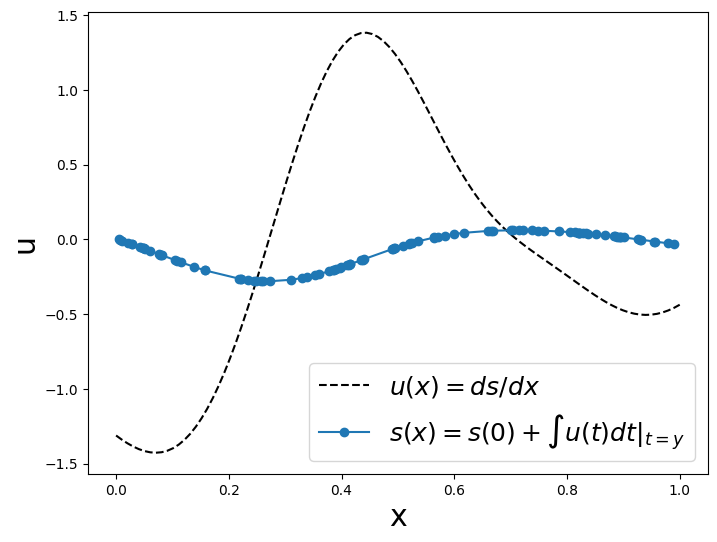

In [10]:
plot_us(x,u,y_train,s_train)

Now, we will have to create many functions for our testing and training dataset, so let's create a pair of programing-functions to generate one random function at a time.

In [11]:
# Generate training data corresponding to one input sample
def generate_one_training_data(key, m=100, P=1):
  # Sample GP prior at a fine grid
  N = 512
  gp_params = (1.0, length_scale)
  jitter = 1e-10
  X = np.linspace(0, 1, N)[:,None]
  K = RBF(X, X, gp_params)
  L = np.linalg.cholesky(K + jitter*np.eye(N))
  gp_sample = np.dot(L, random.normal(key, (N,)))

  # Create a callable interpolation function
  u_fn = lambda x, t: np.interp(t, X.flatten(), gp_sample)

  # Input sensor locations and measurements
  x = np.linspace(0, 1, m)
  u = vmap(u_fn, in_axes=(None,0))(0.0, x)

  # Output sensor locations and measurements
  y_train = random.uniform(key, (P,)).sort()
  s_train = odeint(u_fn, 0.0, np.hstack((0.0, y_train)))[1:] # JAX has a bug and always returns s(0), so add a dummy entry to y and return s[1:]

  # Tile inputs
  u_train = np.tile(u, (P,1))

  return u_train, y_train, s_train


In [12]:
# Geneate test data corresponding to one input sample
def generate_one_test_data(key, m=100, P=100):
    # Sample GP prior at a fine grid
    N = 512
    gp_params = (1.0, length_scale)
    jitter = 1e-10
    X = np.linspace(0, 1, N)[:,None]
    K = RBF(X, X, gp_params)
    L = np.linalg.cholesky(K + jitter*np.eye(N))
    gp_sample = np.dot(L, random.normal(key, (N,)))

    # Create a callable interpolation function
    u_fn = lambda x, t: np.interp(t, X.flatten(), gp_sample)

    # Input sensor locations and measurements
    x = np.linspace(0, 1, m)
    u = vmap(u_fn, in_axes=(None,0))(0.0, x)

    # Output sensor locations and measurements
    y = np.linspace(0, 1, P)
    s = odeint(u_fn, 0.0, y)

    # Tile inputs
    u = np.tile(u, (P,1))

    return u, y, s

# Network

MLP: multi layer perceptron.

https://pytorch.org/vision/main/generated/torchvision.ops.MLP.html

A DeepONet is a neural network architecture designed to learn mappings between function spaces, effectively approximating operators that map one function to another. This is achieved through two primary components:

* **Branch Network:** Processes the input function, which is typically represented by discrete values.
Encodes the characteristics of the input function into a latent representation.

* **Trunk Network:** Handles the locations or coordinates where the output function is evaluated.
Encodes spatial or temporal information relevant to the problem.
The outputs of these two networks are combined, often through an inner product or element-wise multiplication, to produce the final output, which represents the evaluated operator at specific points.



In [14]:
class DeepONet:
  def __init__(self, branch_layers, trunk_layers):

    # Network initialization and evaluation functions
    self.branch_init, self.branch_apply = MLP(branch_layers, activation=relu)
    self.trunk_init, self.trunck_apply =  MLP(trunk_layers, activation=relu)

    # Initialization
    branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
    trunk_params = self.trunk_init(rng_key = random.PRNGKey(42))

    params = (branch_params, trunk_params)

    # Use optimizers to set optimizer initialization and update functions
    self.opt_init, \
    self.opt_update, \
    self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3,
                                                                   decay_steps=1000,
                                                                   decay_rate=0.9))
    self.opt_state = self.opt_init(params)
    self.itercount = itertools.count() # counting the iterations

    # Logger
    self.loss_log = []

  # Define operator net
  def operator_net(self, params, u, y):
    branch_params, trunk_params = params
    B = self.branch_apply(branch_params, u)
    T = self.trunk_apply(trunk_params, y)
    outputs = np.sum(B * T)
    return outputs

  # Define ODE/PDE residual
  def residual_net(self, params, u, y):
    s_y = grad(self.operator_net, argnums = 2)(params, u, y)
    return s_y

  # Define loss
  def loss(self, params, batch):
    # Fetch data

